In [2]:
using Pkg
#Pkg.add("Distributions")
using Random, Distributions
using PyPlot
using Optim

In [3]:
#coordination game

#player, action 1, action 2
payoffs = [ [3 -1 ; 0 0], [1 -3 ; 0 0] ]

#player, action (not yours)
priors = [[3 1 ; 3 1],[1 3 ; 1 3]]
mix = [.5 ; .5]

function simulate_game(payoffs,mix; 
        beliefs=[[3 1 ; 3 1],[1 3 ; 1 3]],T=5,update=true)
    
    #infer # of players and actions
    players = 2
    actions = 2
    trial = zeros(T,players)
    
    #choose a prior
    beliefs_distr = Categorical(mix)
    beliefs = beliefs[rand(beliefs_distr)]
    beliefs = beliefs[:,:]
    
    for t =1:T
        choices = []
        for k=1:players
            expected_payoffs = []
            for i=1:actions
                belief_t = beliefs[k,:]/sum(beliefs[k,:])
                payoff = sum( belief_t .* payoffs[k][i,:]) + rand(Gumbel())
                append!(expected_payoffs,payoff)
            end
            append!(choices,argmax(expected_payoffs))
        end
        for k=1:players
            if choices[k]==1
                trial[t,k] = 1
            end
            
            if update
                not_k = mod(k,2)+1
                beliefs[k,choices[not_k]] = beliefs[k,choices[not_k]] +1
            end
        end
    end
    
    return trial
end


simulate_game(payoffs,mix)

5×2 Array{Float64,2}:
 0.0  0.0
 1.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0

In [4]:
function gen_support(t) 
    result = zeros(2^(2*t),t,2)
    for i=1:2^(2*t)
        i_copy = i
        binary = zeros(2*t)
        for digit=1:2*t
            if mod(i_copy,2) > 0
                binary[digit] = 1
                i_copy = i_copy - 1
            end
            i_copy = i_copy/2
        end
        result[i,:,1] = binary[1:t]
        result[i,:,2] = binary[t+1:end]
    end
    return result
end


gen_support (generic function with 1 method)

[1.0 0.0; 0.0 0.0] 1

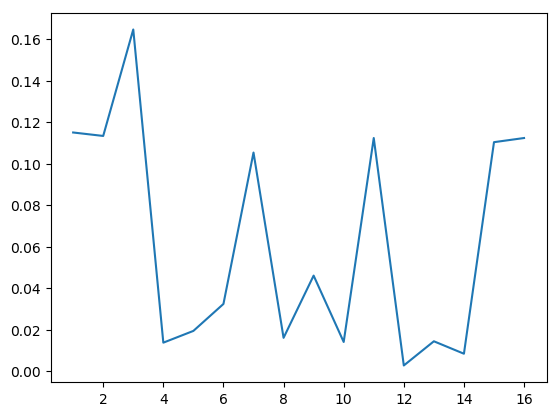


[0.0 0.0; 1.0 0.0] 2
[1.0 0.0; 1.0 0.0] 3
[0.0 1.0; 0.0 0.0] 4
[1.0 1.0; 0.0 0.0] 5
[0.0 1.0; 1.0 0.0] 6
[1.0 1.0; 1.0 0.0] 7
[0.0 0.0; 0.0 1.0] 8
[1.0 0.0; 0.0 1.0] 9
[0.0 0.0; 1.0 1.0] 10
[1.0 0.0; 1.0 1.0] 11
[0.0 1.0; 0.0 1.0] 12
[1.0 1.0; 0.0 1.0] 13
[0.0 1.0; 1.0 1.0] 14
[1.0 1.0; 1.0 1.0] 15
[0.0 0.0; 0.0 0.0] 16


In [5]:
#set up a non-linear equation for each distr
function empirical_pr_sim(payoffs,mix; 
        beliefs=[[3 1 ; 3 1],[1 3 ; 1 3]],T=5,N=3000)
    #enumerate outcomes
    outcomes = gen_support(T)
    outcomes_pr = zeros(size(outcomes)[1])
    Random.seed!(123)
    
    for i=1:N
        draw = simulate_game(payoffs,mix; beliefs=beliefs,T=T)
        for j=1:2^(2*T)
            if draw == outcomes[j,:,:]
                outcomes_pr[j] = outcomes_pr[j]+1
            end
        end
    end
    return outcomes_pr/N
end

#player, action 1, action 2
payoffs = [ [3 -1 ; 0 0], [1 -3 ; 0 0] ]

#player, action (not yours)
mix = [.5 ; .5]

T=2
sim_pr = empirical_pr_sim(payoffs,mix,T=T;)
plot(collect(1:2^(2*T)), sim_pr)

support = gen_support(T)
for i=1:2^(2*T)
    println(support[i,:,:]," $(i)")
end

In [19]:
function gmm_obj_payoffs(params, obs_pr ; T=5)   
    
    #initialize array of 0s
    moments = zeros( 2^(2*T) +1)
    
    #deal with probability parameters
    mix = [max(params[5],0) ; max(params[6],0)]
    denom = sum(mix)
    mix = mix/denom
    moments[1] = (denom -1)
    
    
    #simulate the rest of the equations
    payoffs = [ [ params[1] params[2]; 0 0 ], [params[3] params[4] ; 0 0] ]
    #subtract simulated from reality
    moments[2:end] = obs_pr - empirical_pr_sim(payoffs, mix ; T=T)
    result = sum(moments .* moments)
    println(result," ",params)
    return result
end

#player, action 1, action 2
payoffs = [ [3 -1 ; 0 0], [1 -3 ; 0 0] ]
#player, action (not yours)
mix = [0.5 ; 0.5]
T=2
sim_pr = empirical_pr_sim(payoffs,mix;T=T)
gmm_obj_payoffs( [3 -1 1 -3 .5 .5], sim_pr ;T=T)

0.0 [3.0 -1.0 1.0 -3.0 0.5 0.5]


0.0

In [20]:
function estimate_payoffs(obs_pr; T=5)
    obj(x) = gmm_obj_payoffs(x, obs_pr ;T=T)
        
    res = optimize(obj,[1. 1. 1. 1. .5 .5], NelderMead(),
        Optim.Options(iterations = 1000,x_tol=1e-20,f_tol=1e-20))
    return res.minimizer
end

#player, action 1, action 2
payoffs = [ [3. -1. ; 0. 0.], [1. -3. ; 0. 0.] ]
#player, action (not yours)
mix = [0.5 ; 0.5]
T=3
sim_pr = empirical_pr_sim(payoffs,mix;T=T)

println(estimate_payoffs(sim_pr; T=T))

0.036155555555555566 [1.0 1.0 1.0 1.0 0.5 0.5]
0.036155555555555566 [1.0 1.0 1.0 1.0 0.5 0.5]
0.04143711111111111 [1.525 1.0 1.0 1.0 0.5 0.5]
0.03983 [1.0 1.525 1.0 1.0 0.5 0.5]
0.050498 [1.0 1.0 1.525 1.0 0.5 0.5]
0.04703533333333334 [1.0 1.0 1.0 1.525 0.5 0.5]
0.11178055555555554 [1.0 1.0 1.0 1.0 0.775 0.5]
0.11178055555555554 [1.0 1.0 1.0 1.0 0.5 0.775]
0.08253400000000002 [1.175 1.175 1.175 1.175 0.591667 0.225]
0.16648690123456794 [1.23333 1.23333 1.23333 1.23333 0.255556 0.408333]
0.06848339231824413 [1.03889 1.03889 1.03889 1.03889 0.688426 0.484722]
0.09483013824112178 [1.01296 1.01296 1.01296 1.01296 0.471142 0.769907]
0.05917963095480029 [1.14799 1.14799 1.14799 1.14799 0.571579 0.315818]
0.09403531346330075 [1.18544 1.18544 1.18544 1.18544 0.335434 0.453884]
0.052184149309469206 [1.06331 1.06331 1.06331 1.06331 0.629594 0.479582]
0.06141529030078879 [1.04811 1.04811 1.04811 1.04811 0.471619 0.677376]
0.050035223871140955 [1.13135 1.13135 1.13135 1.13135 0.554919 0.376078]
0.

0.011501708959381811 [0.421608 1.05849 -0.469672 -0.0542747 0.573919 0.416981]
0.011649039903185856 [0.588875 1.00158 -0.502257 0.153828 0.559876 0.451601]
0.01159680585501758 [0.739118 1.12206 -0.249058 -0.00166315 0.558136 0.442878]
0.011830129715401743 [0.795468 0.945883 -0.350089 0.220729 0.590227 0.414593]
0.011683273110441254 [0.727267 0.994719 -0.405027 0.201846 0.580905 0.422768]
0.011345941114226548 [0.615775 0.856544 -0.480385 -0.00828957 0.545418 0.455203]
0.011178536988284513 [0.617357 0.791825 -0.474895 -0.060138 0.539729 0.460576]
0.011646070771842647 [0.458155 1.03905 -0.611969 0.00533687 0.530342 0.468004]
0.011093499707620025 [0.693962 0.902208 -0.491799 -0.102935 0.570482 0.43474]
0.01103062394475329 [0.7291 0.867837 -0.482617 -0.159078 0.57587 0.430693]
0.011308214080687459 [0.634963 0.964476 -0.529886 -0.127142 0.554097 0.435195]
0.011137464882721103 [0.824619 0.90215 -0.392812 -0.0228109 0.591549 0.407856]
0.010866493933335475 [0.635518 0.916285 -0.136295 -0.386651

0.0001842678696688723 [2.72528 -0.885167 0.993593 -3.16389 0.553423 0.444565]
0.00010565967115709253 [2.67668 -0.884363 1.11893 -3.33851 0.538367 0.462511]
0.00016226348581789346 [2.66056 -0.864991 1.14977 -3.37912 0.531785 0.468728]
0.00015143160180061023 [2.84945 -1.01632 1.10277 -3.28773 0.538427 0.467277]
0.00023257305765748024 [2.71897 -1.05221 1.07754 -3.39245 0.547379 0.452029]
0.00015081015612825125 [2.76565 -0.910024 1.04528 -3.18106 0.55277 0.451567]
0.00028499859316791616 [2.82996 -0.936856 1.2496 -3.40373 0.552412 0.450474]
0.00014688191475077666 [2.71284 -0.968818 0.967766 -3.1847 0.550239 0.452299]
0.00023852486411060587 [2.8618 -0.924968 0.940417 -3.20564 0.545927 0.454357]
0.00014246780426086506 [2.70312 -0.972935 1.12122 -3.28461 0.553302 0.450443]
0.00028927903141093313 [2.80052 -1.05159 1.14674 -3.38239 0.547239 0.461411]
0.00011694381652974258 [2.73782 -0.912903 1.01912 -3.20031 0.552393 0.447373]
0.0001699735375459095 [2.6122 -0.830651 1.05999 -3.13004 0.526282 0.4

6.133836956242174e-5 [2.72003 -0.933255 1.08479 -3.3343 0.550577 0.449352]
6.622232463610187e-5 [2.73428 -0.933196 1.08768 -3.33527 0.550532 0.449458]
6.340826949497213e-5 [2.7272 -0.943639 1.08012 -3.32937 0.551176 0.449098]
6.689106538764774e-5 [2.73286 -0.935284 1.08617 -3.33409 0.550661 0.449386]
6.161120251522957e-5 [2.72814 -0.942246 1.08113 -3.33016 0.55109 0.449146]
6.762258623440733e-5 [2.72751 -0.942869 1.08386 -3.30914 0.550535 0.45055]
6.428377171983792e-5 [2.73079 -0.93848 1.08239 -3.34176 0.551129 0.448622]
6.143383966842213e-5 [2.72775 -0.936127 1.08029 -3.32373 0.549242 0.451075]
6.181645903085457e-5 [2.72723 -0.941079 1.08163 -3.33071 0.551023 0.449174]
6.06928681609696e-5 [2.72823 -0.936798 1.08017 -3.32525 0.551576 0.448586]
6.330087500197469e-5 [2.73284 -0.944343 1.08717 -3.3347 0.551184 0.449252]
6.298835286113807e-5 [2.73134 -0.94283 1.08564 -3.32918 0.551434 0.448881]
6.307284410647181e-5 [2.72998 -0.937209 1.08244 -3.34581 0.551155 0.448416]
6.47282092976225e-5 

In [21]:
#player, action 1, action 2
payoffs = [ [3. -1. ; 0. 0.], [1. -3. ; 0. 0.] ]
#player, action (not yours)
mix = [0.2 ; 0.8]
T=4
sim_pr = empirical_pr_sim(payoffs,mix;T=T)

println(estimate_payoffs(sim_pr; T=T))

0.02717933333333333 [1.0 1.0 1.0 1.0 0.5 0.5]
0.02717933333333333 [1.0 1.0 1.0 1.0 0.5 0.5]
0.033975111111111116 [1.525 1.0 1.0 1.0 0.5 0.5]
0.031470888888888895 [1.0 1.525 1.0 1.0 0.5 0.5]
0.033853333333333326 [1.0 1.0 1.525 1.0 0.5 0.5]
0.03218422222222223 [1.0 1.0 1.0 1.525 0.5 0.5]
0.10280433333333333 [1.0 1.0 1.0 1.0 0.775 0.5]
0.10280433333333333 [1.0 1.0 1.0 1.0 0.5 0.775]
0.06906844444444449 [1.175 1.175 1.175 1.175 0.591667 0.225]
0.15186867901234571 [1.23333 1.23333 1.23333 1.23333 0.255556 0.408333]
0.058432281207133015 [1.03889 1.03889 1.03889 1.03889 0.688426 0.484722]
0.08573036046334401 [1.01296 1.01296 1.01296 1.01296 0.471142 0.769907]
0.046781408732578064 [1.14799 1.14799 1.14799 1.14799 0.571579 0.315818]
0.08049798012996744 [1.18544 1.18544 1.18544 1.18544 0.335434 0.453884]
0.041386371531691425 [1.06331 1.06331 1.06331 1.06331 0.629594 0.479582]
0.051029290300788795 [1.04811 1.04811 1.04811 1.04811 0.471619 0.677376]
0.03770544609336317 [1.13135 1.13135 1.13135 1.1

0.002342717768876957 [0.474883 -0.883193 -1.49876 -1.74304 0.559432 0.447238]
0.0035456856431505808 [0.0418462 -0.492217 -2.2994 -1.55944 0.513407 0.501726]
0.0029291257934681418 [0.0338066 -0.473738 -2.14986 -1.46363 0.500915 0.509229]
0.004879521334134202 [0.0971309 -0.127811 -1.86524 -1.64868 0.517317 0.517959]
0.0029126505578762237 [-0.0153162 -0.586091 -1.90646 -1.13931 0.462167 0.523985]
0.0034986360500610628 [0.178711 -0.935738 -1.97262 -0.891742 0.413185 0.581547]
0.0028317676696930105 [-0.0480219 -0.196696 -1.85552 -1.50747 0.512192 0.49459]
0.0033444576959658677 [0.142165 -0.551866 -1.99946 -1.79013 0.505207 0.480028]
0.0028417200459621007 [-0.0218242 -0.403431 -1.8481 -1.07005 0.46589 0.544743]
0.0037643860862964776 [-0.062209 -0.779101 -1.86507 -1.50795 0.516423 0.49744]
0.0027379114882615705 [0.07868 -0.305467 -1.916 -1.22938 0.462388 0.534066]
0.0028777919934270453 [0.285026 -0.353549 -1.71732 -1.40509 0.551074 0.45119]
0.0029670137402069865 [0.174346 -0.393333 -1.45773 -

0.00138917543782307 [1.45147 -1.40343 -0.296157 -3.09596 0.774575 0.223523]
0.0014857029038670671 [1.24585 -1.17215 -0.536825 -2.85294 0.721038 0.277657]
0.0015540555061600318 [1.54255 -1.40653 -0.129115 -3.11966 0.784027 0.214257]
0.0014594419167516031 [1.2953 -1.21122 -0.468874 -2.89739 0.731536 0.267091]
0.0014491584664283945 [1.4931 -1.36747 -0.197067 -3.0752 0.773529 0.224824]
0.0014238989861335243 [1.46014 -1.34143 -0.242368 -3.04557 0.76653 0.231868]
0.0013777916567193663 [1.32827 -1.23726 -0.423573 -2.92703 0.738535 0.260046]
0.0014020271830440013 [1.29587 -1.11986 -0.412255 -2.82033 0.718477 0.280566]
0.001360822867089911 [1.42554 -1.35617 -0.315507 -3.05002 0.765225 0.23303]
0.0013144859580965405 [1.40462 -1.27557 -0.298951 -3.12734 0.763839 0.237003]
0.001288301761046838 [1.41148 -1.27569 -0.284447 -3.17286 0.768109 0.233408]
0.0013793340737417547 [1.46751 -1.32595 -0.214976 -3.13647 0.773378 0.226649]
0.0013420544879784388 [1.35148 -1.25204 -0.388806 -2.96194 0.744342 0.254

0.0012697890828811437 [1.37891 -1.26361 -0.31486 -3.07824 0.755238 0.244656]
0.0012652301196821216 [1.37814 -1.2646 -0.309445 -3.08892 0.754878 0.244777]
0.001258485731834035 [1.37162 -1.25805 -0.314948 -3.07371 0.752699 0.246788]
0.0012696710875727624 [1.37041 -1.25713 -0.314962 -3.07296 0.752276 0.247143]
0.0012761688552458822 [1.3787 -1.25829 -0.308355 -3.08617 0.753923 0.245294]
0.0012582405265030385 [1.37293 -1.26142 -0.317915 -3.07083 0.753725 0.24614]
0.0012648864319948672 [1.37448 -1.26288 -0.323665 -3.0673 0.753307 0.246028]
0.001278750598928634 [1.37035 -1.25615 -0.326826 -3.05386 0.752063 0.247384]
0.0012614775045664472 [1.37684 -1.26319 -0.312342 -3.08307 0.754409 0.245212]
0.001266019161805672 [1.3748 -1.25797 -0.308832 -3.08074 0.754001 0.245861]
0.001262777476040378 [1.37453 -1.26206 -0.321193 -3.06954 0.753423 0.246]
0.0012646721282163545 [1.37885 -1.26557 -0.310921 -3.06828 0.753684 0.246242]
0.0012590128632540727 [1.37269 -1.25841 -0.31972 -3.07572 0.753592 0.24582]
0

0.0012402360332565622 [1.37174 -1.25721 -0.310796 -3.08884 0.753642 0.24624]
0.0012388895087509662 [1.37091 -1.25596 -0.310795 -3.08959 0.753657 0.246318]
0.0012388889783768603 [1.37077 -1.25575 -0.310795 -3.08972 0.75366 0.246331]
0.0012444546947571015 [1.37011 -1.25686 -0.312217 -3.08732 0.75362 0.246279]
0.001240224209441611 [1.37176 -1.25628 -0.310144 -3.0902 0.753666 0.24629]
0.0012388935930935528 [1.37029 -1.25563 -0.31003 -3.09142 0.753547 0.246384]
0.0012388952711888022 [1.37126 -1.25712 -0.310367 -3.0895 0.753793 0.246127]
0.0012395561997272093 [1.37129 -1.25643 -0.312205 -3.08907 0.753726 0.246249]
0.0012395700682899182 [1.37123 -1.25617 -0.311506 -3.08834 0.753567 0.246313]
0.0012400017553185602 [1.37145 -1.25722 -0.310757 -3.08689 0.753603 0.246355]
0.0012402230795934659 [1.37187 -1.2561 -0.309906 -3.0906 0.753672 0.246298]
0.0012395629423548982 [1.37022 -1.25667 -0.31198 -3.08772 0.753627 0.246287]
0.0012435633020539917 [1.37023 -1.25537 -0.311537 -3.0917 0.753704 0.246208

0.0012346666684755357 [1.37116 -1.2563 -0.309426 -3.09057 0.753715 0.246284]
0.0012351112506744563 [1.37134 -1.25649 -0.309201 -3.09017 0.753717 0.246271]
0.001234666676213122 [1.37119 -1.25633 -0.309388 -3.0905 0.753715 0.246282]
0.0012344444526446675 [1.3712 -1.25629 -0.309142 -3.09065 0.753713 0.246284]
0.0012344444495873508 [1.37128 -1.25648 -0.309477 -3.09011 0.75374 0.246262]
0.0012344445000475024 [1.37121 -1.25644 -0.309227 -3.09049 0.753719 0.246273]
0.0012344445139357138 [1.37133 -1.25644 -0.309344 -3.09031 0.753722 0.246269]
0.0012344447169550146 [1.37123 -1.25631 -0.309377 -3.0903 0.753685 0.246298]
0.0012346666691936642 [1.37118 -1.25632 -0.309407 -3.09053 0.753715 0.246283]
0.001235111217481714 [1.37133 -1.25647 -0.30922 -3.09021 0.753717 0.246272]
0.0012346666759304504 [1.3712 -1.25635 -0.309376 -3.09048 0.753716 0.246281]
0.0012344444483110748 [1.37128 -1.25643 -0.309341 -3.09032 0.753721 0.246277]
0.0012344444484779934 [1.37121 -1.25633 -0.309198 -3.09056 0.753718 0.246

In [24]:
#player, action 1, action 2
payoffs = [ [1. -1. ; 0. 0.], [-1. 1. ; 0. 0.] ]
#player, action (not yours)
mix = [0.2 ; 0.8]
T=5
sim_pr = empirical_pr_sim(payoffs,mix;T=T)

println(estimate_payoffs(sim_pr; T=T))

0.006561333333333333 [1.0 1.0 1.0 1.0 0.5 0.5]
0.006561333333333333 [1.0 1.0 1.0 1.0 0.5 0.5]
0.01071488888888889 [1.525 1.0 1.0 1.0 0.5 0.5]
0.009265777777777777 [1.0 1.525 1.0 1.0 0.5 0.5]
0.010001555555555555 [1.0 1.0 1.525 1.0 0.5 0.5]
0.008488 [1.0 1.0 1.0 1.525 0.5 0.5]
0.08218633333333335 [1.0 1.0 1.0 1.0 0.775 0.5]
0.08218633333333335 [1.0 1.0 1.0 1.0 0.5 0.775]
0.04449733333333335 [1.175 1.175 1.175 1.175 0.591667 0.225]
0.12579845679012364 [1.23333 1.23333 1.23333 1.23333 0.255556 0.408333]
0.037242503429355256 [1.03889 1.03889 1.03889 1.03889 0.688426 0.484722]
0.06492480490778839 [1.01296 1.01296 1.01296 1.01296 0.471142 0.769907]
0.022808519843689184 [1.14799 1.14799 1.14799 1.14799 0.571579 0.315818]
0.0555882023521896 [1.18544 1.18544 1.18544 1.18544 0.335434 0.453884]
0.019646593753913644 [1.06331 1.06331 1.06331 1.06331 0.629594 0.479582]
0.029649956967455475 [1.04811 1.04811 1.04811 1.04811 0.471619 0.677376]
0.014338557204474281 [1.13135 1.13135 1.13135 1.13135 0.554

0.0004728846356405981 [-0.0502533 -0.0454217 -0.638108 1.1934 0.575365 0.425102]
0.0005694284157750599 [-0.0326486 -0.0373315 -0.219118 1.24891 0.593479 0.411102]
0.000533365848313726 [-0.0260639 -0.150139 -0.266758 1.15436 0.585789 0.406182]
0.0005250923596609542 [-0.44971 0.150836 -0.40378 1.08027 0.582125 0.423704]
0.0005755292416521245 [-0.520686 0.273668 -0.90916 1.30912 0.571965 0.421539]
0.00051192311484247 [-0.113988 0.0145017 -0.334125 1.25895 0.589893 0.412842]
0.00047311862936130615 [0.0362742 -0.131994 -0.360648 1.12825 0.609095 0.387162]
0.0005651779692395603 [0.145115 -0.14287 0.0747423 0.914728 0.579698 0.423743]
0.0005129769611238927 [-0.330472 0.130407 -0.746831 1.38788 0.594843 0.401745]
0.0005990245277206415 [-0.35588 0.285847 -0.72967 1.32071 0.5948 0.413427]
0.0004967491627663378 [-0.0810333 -0.0774744 -0.34391 1.18209 0.587291 0.407389]
0.00043868483350707846 [-0.0920453 -0.275179 -0.436677 1.03378 0.589093 0.411042]
0.0004214710176600327 [-0.0677725 -0.369175 -0.

0.0003076120801159057 [0.51729 -0.917992 -0.507633 0.854498 0.551468 0.44877]
0.0002926691907646187 [0.538182 -0.900197 -0.535731 0.852042 0.554335 0.445615]
0.0002987166944551974 [0.553723 -0.912128 -0.475173 0.867586 0.549755 0.450022]
0.00029947519305700647 [0.494273 -0.892546 -0.44677 0.823916 0.551014 0.449363]
0.0003036397086300472 [0.469527 -0.853392 -0.520746 0.870619 0.551406 0.449959]
0.0002989540102579716 [0.490121 -0.854251 -0.528956 0.875844 0.547721 0.452815]
0.0003046922268854873 [0.506632 -0.843344 -0.496583 0.859991 0.549009 0.451677]
0.0003074107783250068 [0.526944 -0.932067 -0.511979 0.851234 0.550564 0.449714]
0.00030193709519616904 [0.510017 -0.858131 -0.499149 0.858532 0.549268 0.451349]
0.0003024219973705597 [0.577546 -0.923598 -0.480618 0.836577 0.547455 0.451895]
0.0003016541034528221 [0.559542 -0.911897 -0.487306 0.842251 0.548113 0.451573]
0.0003049343916558416 [0.553563 -0.936781 -0.498266 0.843237 0.549208 0.450579]
0.0003002296216154829 [0.517275 -0.87124 

0.0002916281877521484 [0.539262 -0.898081 -0.534937 0.853813 0.55172 0.448549]
0.0002921190288082459 [0.536491 -0.898032 -0.530638 0.851173 0.550749 0.449596]
0.0002911854116201371 [0.534396 -0.895624 -0.529408 0.851955 0.551616 0.448656]
0.00029275710407941635 [0.538811 -0.901449 -0.528909 0.846792 0.552002 0.448298]
0.0002941071582392573 [0.529844 -0.893356 -0.530602 0.853786 0.551593 0.448734]
0.00029337126167888034 [0.544974 -0.903982 -0.531364 0.848284 0.55196 0.448235]
0.00029360258022857494 [0.542452 -0.902211 -0.531237 0.849201 0.551899 0.448318]
0.0002913781620204173 [0.538957 -0.900555 -0.528744 0.850685 0.552066 0.448146]
0.00029095293372655064 [0.534652 -0.895971 -0.530239 0.851974 0.551783 0.44847]
0.00028984053111437224 [0.538707 -0.898018 -0.534846 0.853523 0.55187 0.448381]
0.00029254267930974 [0.536398 -0.897978 -0.531264 0.851323 0.55106 0.449253]
0.00029252091140453414 [0.538332 -0.900825 -0.529823 0.847672 0.552105 0.448172]
0.0002925336731602872 [0.530859 -0.894081

0.0002889373233012732 [0.537898 -0.897005 -0.533542 0.853793 0.552147 0.448073]
0.000288038156659537 [0.538464 -0.897619 -0.534342 0.853781 0.552365 0.44783]
0.00028959211827808077 [0.538558 -0.897722 -0.534476 0.85378 0.552401 0.44779]
0.0002889287968753549 [0.538424 -0.897643 -0.534322 0.853499 0.552344 0.447856]
0.0002902646516078453 [0.538585 -0.897453 -0.534504 0.854 0.552301 0.447905]
0.0002889303707279221 [0.538129 -0.897416 -0.533886 0.853583 0.552284 0.447919]
0.0002887074640418298 [0.538019 -0.89711 -0.534759 0.85401 0.552306 0.447896]
0.0002887088564307793 [0.538729 -0.897751 -0.53388 0.853633 0.55222 0.447986]
0.00028871560822931234 [0.538107 -0.89724 -0.534019 0.853861 0.552196 0.448025]
0.00028892704545840627 [0.538269 -0.897415 -0.533683 0.853701 0.552386 0.447809]
0.0002889285022587302 [0.538431 -0.897639 -0.534326 0.853546 0.552348 0.447851]
0.0002889296510723918 [0.538109 -0.897444 -0.533859 0.853547 0.552295 0.447907]
0.0002893750348547312 [0.538564 -0.897481 -0.5344